In [1]:
seed = 100

In [ ]:
from transformers import RobertaModel, RobertaTokenizer
import torch
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load model and tokenizer
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Function to get CLS embeddings in batches
def get_cls_embeddings_batched(texts, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
        batch_texts = texts[i : i + batch_size]
        tokens = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        tokens = {key: val.to(device) for key, val in tokens.items()}
        with torch.no_grad():
            outputs = model(**tokens)
        cls_batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(cls_batch_embeddings)
    return torch.cat(embeddings, dim=0)


# Load data
dataset = "dataset"
df_train = pd.read_csv(f"{dataset}/train.csv")
df_test = pd.read_csv(f"{dataset}/test.csv")

# Sample a smaller subset for visualization (e.g., 10%)
train_sampled = df_train.sample(frac=0.05, random_state=seed)
test_sampled = df_test.sample(frac=0.1, random_state=seed)

train_texts = train_sampled["text"].tolist()
test_texts = test_sampled["text"].tolist()

# Compute embeddings for the sampled data
train_embeddings = get_cls_embeddings_batched(train_texts, batch_size=16)
test_embeddings = get_cls_embeddings_batched(test_texts, batch_size=16)

# Combine embeddings for PCA
combined_embeddings = (
    torch.cat([train_embeddings, test_embeddings], dim=0).cpu().numpy()
)

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_embeddings)


plt.figure(figsize=(12, 9))
plt.scatter(
    reduced_embeddings[: len(train_texts), 0],
    reduced_embeddings[: len(train_texts), 1],
    label="Train",
    alpha=0.5,
    s=10,  # Smaller dot size
)
plt.scatter(
    reduced_embeddings[len(train_texts) :, 0],
    reduced_embeddings[len(train_texts) :, 1],
    label="Test",
    alpha=0.5,
    s=10,  # Smaller dot size
)
plt.legend()
plt.title("Train vs. Test Embedding Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
torch.cuda.empty_cache()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing Batches: 100%|██████████| 4537/4537 [00:49<00:00, 91.37it/s] 


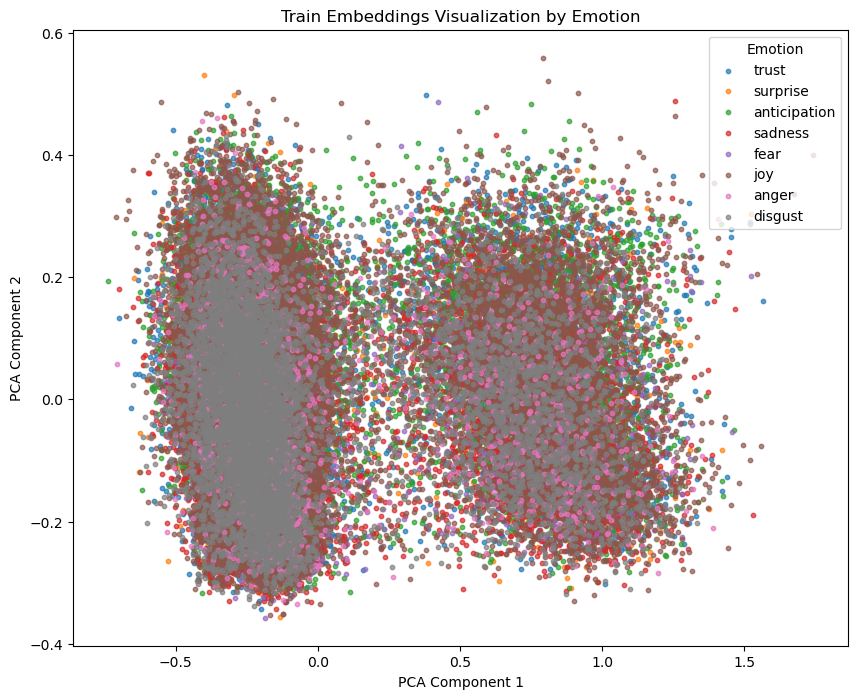

In [ ]:
from transformers import RobertaModel, RobertaTokenizer
import torch
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load model and tokenizer
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Function to get CLS embeddings in batches
def get_cls_embeddings_batched(texts, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
        batch_texts = texts[i : i + batch_size]
        tokens = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        tokens = {key: val.to(device) for key, val in tokens.items()}
        with torch.no_grad():
            outputs = model(**tokens)
        cls_batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(cls_batch_embeddings)
    return torch.cat(embeddings, dim=0)


# Load data
dataset = "dataset"
df_train = pd.read_csv(f"{dataset}/train.csv")
df_test = pd.read_csv(f"{dataset}/test.csv")

# Seed for reproducibility
seed = 42

# Sample a smaller subset for visualization
train_sampled = df_train.sample(frac=0.05, random_state=seed)
test_sampled = df_test.sample(frac=0.1, random_state=seed)

train_texts = train_sampled["text"].tolist()
train_emotions = train_sampled["emotion"].tolist()  # Extract corresponding emotions
test_texts = test_sampled["text"].tolist()

# Compute embeddings for the sampled data
train_embeddings = get_cls_embeddings_batched(train_texts, batch_size=16)

In [ ]:
# PCA on train embeddings
pca = PCA(n_components=2)
train_embeddings_pca = pca.fit_transform(train_embeddings.cpu().numpy())

# Plot train embeddings by emotion class
plt.figure(figsize=(10, 8))
unique_emotions = list(set(train_emotions))
for emotion in unique_emotions:
    indices = [i for i, e in enumerate(train_emotions) if e == emotion]
    plt.scatter(
        train_embeddings_pca[indices, 0],
        train_embeddings_pca[indices, 1],
        label=emotion,
        alpha=0.7,
        s=10,  # Adjust marker size
    )

plt.legend(title="Emotion")
plt.title("Train Embeddings Visualization by Emotion")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to train embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
train_embeddings_tsne = tsne.fit_transform(train_embeddings.cpu().numpy())

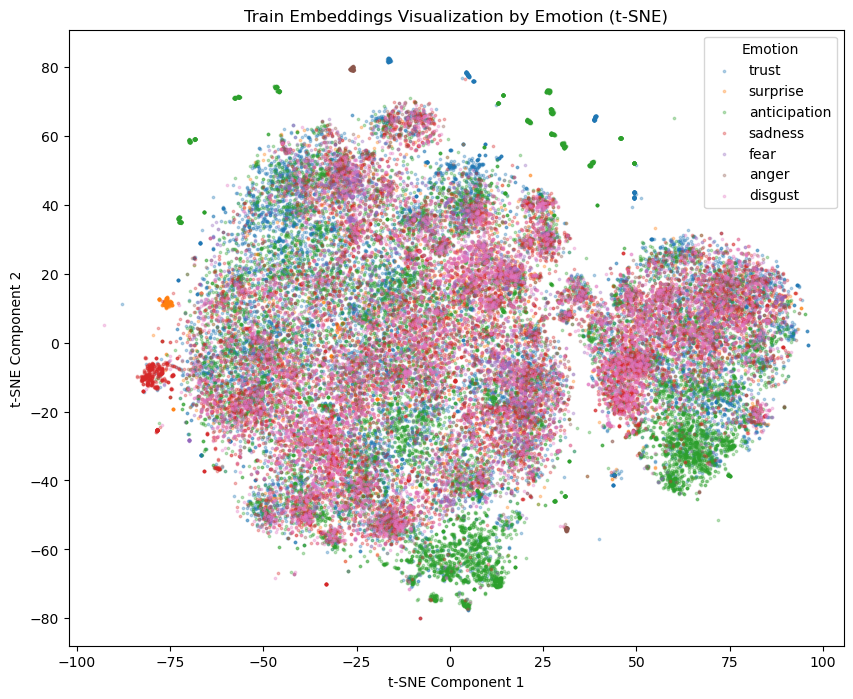

In [ ]:
# Plot train embeddings by emotion class
plt.figure(figsize=(10, 8))
unique_emotions = list(set(train_emotions))

for emotion in unique_emotions:
    if emotion == "joy":
        continue
    indices = [i for i, e in enumerate(train_emotions) if e == emotion]
    plt.scatter(
        train_embeddings_tsne[indices, 0],
        train_embeddings_tsne[indices, 1],
        label=emotion,
        alpha=0.3,
        s=3,  # Adjust marker size
    )

plt.legend(title="Emotion")
plt.title("Train Embeddings Visualization by Emotion (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

/home/S113062628/micromamba/envs/dm_lab_2_test/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


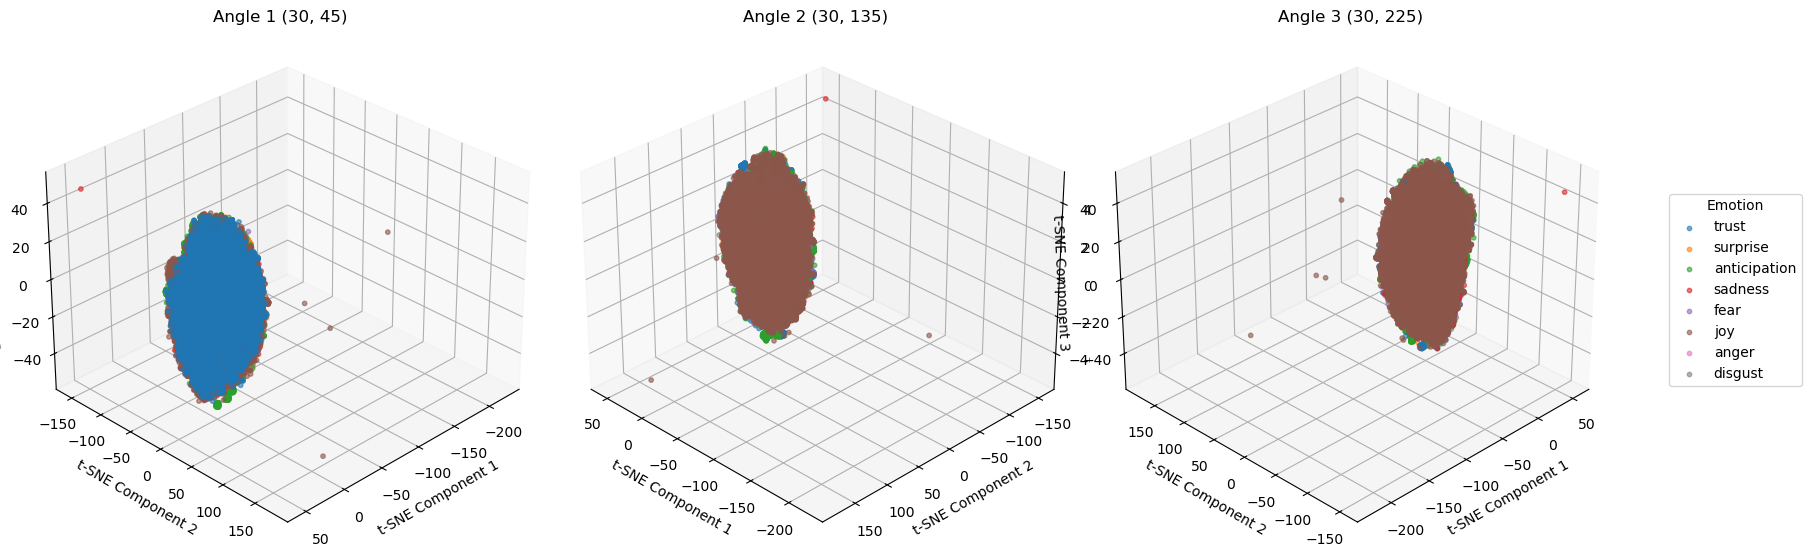

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE with 3 components
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
train_embeddings_tsne_3d = tsne.fit_transform(train_embeddings.cpu().numpy())

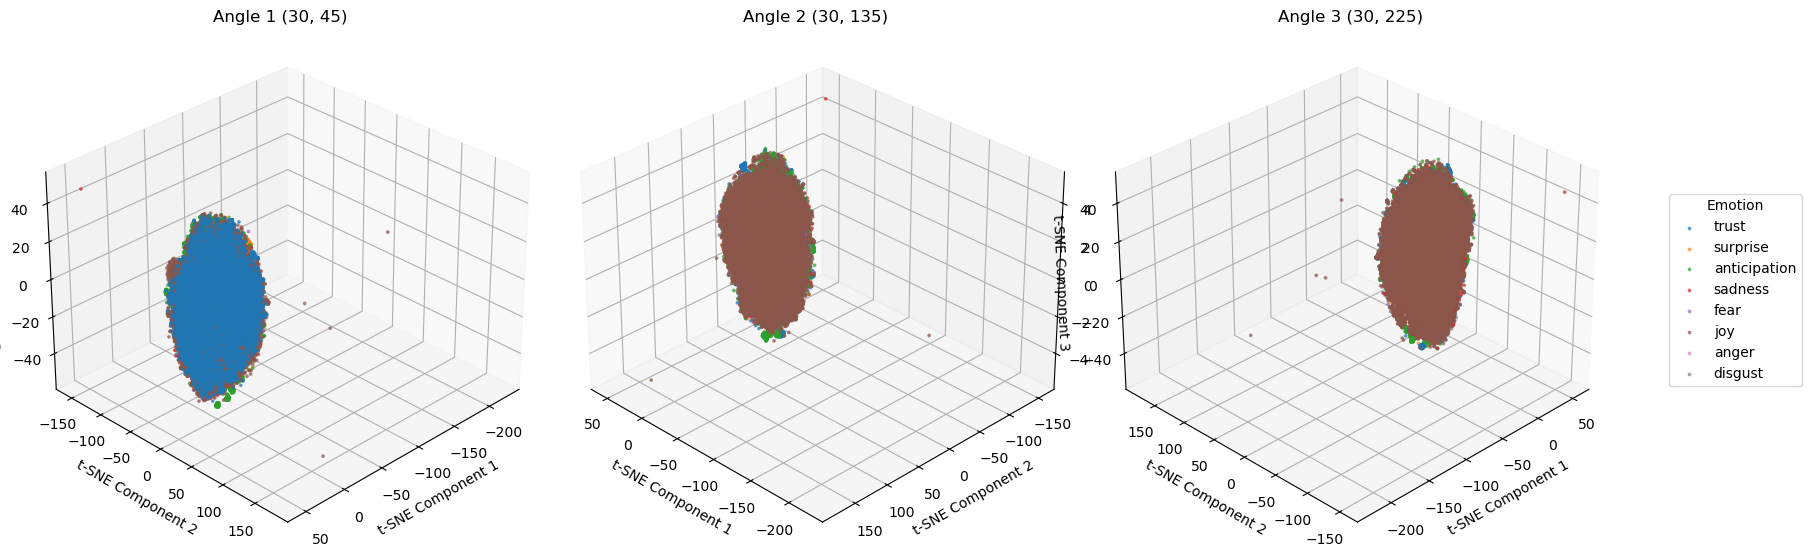

In [ ]:
# Plot train embeddings by emotion class in 3D from different angles
fig = plt.figure(figsize=(18, 6))  # Wide figure to accommodate multiple subplots

angles = [(30, 45), (30, 135), (30, 225)]  # Three angles: (elev, azim)
titles = ["Angle 1 (30, 45)", "Angle 2 (30, 135)", "Angle 3 (30, 225)"]

unique_emotions = list(set(train_emotions))

for i, angle in enumerate(angles):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")  # 3D subplot
    for emotion in unique_emotions:
        indices = [j for j, e in enumerate(train_emotions) if e == emotion]
        ax.scatter(
            train_embeddings_tsne_3d[indices, 0],
            train_embeddings_tsne_3d[indices, 1],
            train_embeddings_tsne_3d[indices, 2],
            label=emotion,
            alpha=0.6,
            s=3,
        )
    ax.set_title(titles[i])
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_zlabel("t-SNE Component 3")
    ax.view_init(elev=angle[0], azim=angle[1])  # Set elevation and azimuth angles

# Add legend to the last subplot only (to avoid repetition)
ax.legend(title="Emotion", bbox_to_anchor=(1.1, 0.5), loc="center left")

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

file = "/home/S113062628/project/Data Mining/DM-Autumn-2024-Lab-2/DM2024-Lab2-Homework/submission.csv"
df = pd.read_csv(file)

df["emotion"] = "joy"
df.to_csv(file, index=False)